In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Utils
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
from datetime import datetime
import json
from IPython.display import display, Audio
from pathlib2 import Path

# Torch
import torch

# wrapper lib
from avgn.utils.paths import DATA_DIR, ensure_dir

DATA_DIR = Path('./data')
DSLOC = DATA_DIR / 'raw' / 'fruitbat'

DATA_SYLLABLES_SIM = DATA_DIR / 'Emitters'

/tmp/ipykernel_3874900/2346212240.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis


In [3]:
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=1, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

In [6]:
# Train model with audio waveforms
#audio = torch.randn(1, 2, 2**18) # [batch_size, in_channels, length]

In [71]:
audio

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [68]:
torch.tensor([waveform]).shape

ValueError: only one element tensors can be converted to Python scalars

In [84]:
wrapped_wave = torch.unsqueeze(waveform_padded, dim=1)

In [58]:
waveform.expand(2,*awaveform.shape[1:])

tensor([[-2.1362e-04,  3.3569e-04, -3.0518e-05,  ...,  2.1362e-04,
         -2.1362e-04, -3.0518e-05],
        [-2.1362e-04,  3.3569e-04, -3.0518e-05,  ...,  2.1362e-04,
         -2.1362e-04, -3.0518e-05]])

In [85]:
loss = model(wrapped_wave)
loss.backward()

In [ ]:
loss = model(waveform.expand(2,*waveform.shape[1:]))
loss.backward()

In [12]:
from IPython.display import display, Audio

In [87]:
# Turn noise into new audio sample with diffusion
noise = torch.randn(1, 1, 2**18) # [batch_size, in_channels, length]
sample = model.sample(noise, num_steps=10) # Suggested num_steps 10-100

In [80]:
waveform_resampled_to_original = torchaudio.transforms.Resample(resample_rate, sample_rate)(waveform_resampled)


In [88]:
Audio(data= sample[0], rate=192000)

In [77]:
# Resample the waveform to 22050
resample_rate = 22050
waveform_resampled = torchaudio.transforms.Resample(sample_rate, resample_rate)(waveform)

# Calculate the number of zero-padding to add on the right
target_length = 262144
current_length = waveform_resampled.shape[-1]
padding_length = target_length - current_length

# Zero-pad the waveform on the right to match the target length
waveform_padded = torch.nn.functional.pad(waveform_resampled, (0, padding_length))



In [78]:
# Check the shapes of the original waveform, resampled waveform, and padded waveform
print("Original waveform shape:", waveform.shape)
print("Resampled waveform shape:", waveform_resampled.shape)
print("Padded waveform shape:", waveform_padded.shape)

Original waveform shape: torch.Size([1, 418640])
Resampled waveform shape: torch.Size([1, 36925])
Padded waveform shape: torch.Size([1, 262144])


In [23]:
import torchaudio

In [28]:
DSLOC / 'zip_contents'/ 'files101'  / '120601000005102988.WAV'

PosixPath('data/raw/fruitbat/zip_contents/files101/120601000005102988.WAV')

In [35]:
waveform, sample_rate = torchaudio.load( DSLOC / 'zip_contents'/ 'files101' /  '120601000005102988.WAV'   )

Sample Rate: 250000
Shape: (1, 418640)
Dtype: torch.float32
 - Max:      0.511
 - Min:     -0.644
 - Mean:     0.000
 - Std Dev:  0.043

tensor([[-2.1362e-04,  3.3569e-04, -3.0518e-05,  ...,  2.1362e-04,
         -2.1362e-04, -3.0518e-05]])



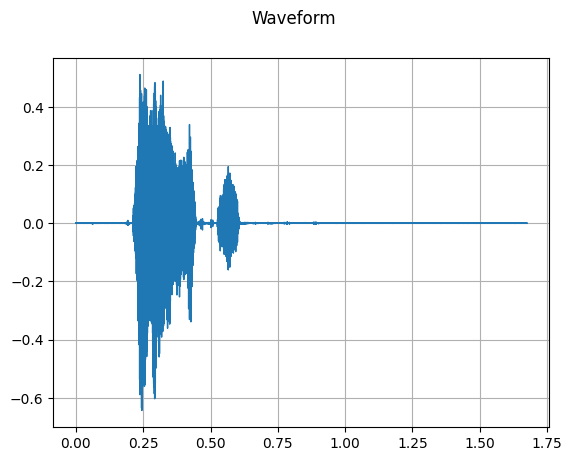

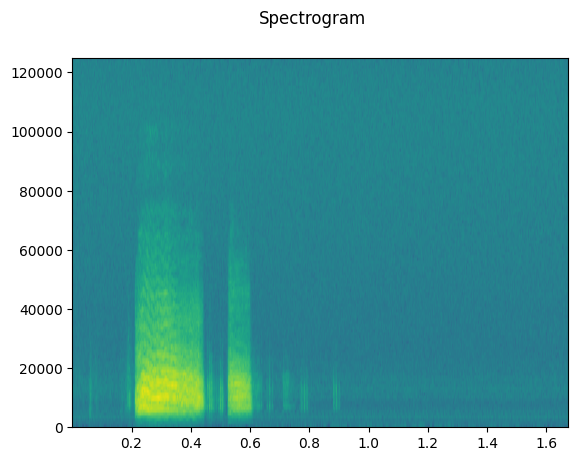

In [47]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, 192000)

In [48]:
# Helpers
import matplotlib
import matplotlib.pyplot as plt

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")
        print()
        print(waveform)
        print()
        
        
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

    
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


In [4]:
import torch
import torchaudio
import gc
import argparse
import os
from tqdm import tqdm
import wandb
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler
from audio_data_pytorch import LibriSpeechDataset, AllTransform

SAMPLE_RATE = 16000
BATCH_SIZE = 12
NUM_SAMPLES = 2**18


def create_model():
    return DiffusionModel(
        net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
        in_channels=1, # U-Net: number of input/output (audio) channels
        channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
        factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
        items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
        attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
        attention_heads=8, # U-Net: number of attention heads per attention item
        attention_features=64, # U-Net: number of attention features per attention item
        diffusion_t=VDiffusion, # The diffusion method used
        sampler_t=VSampler, # The diffusion sampler used
    )


def main():
    args = parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = LibriSpeechDataset(
        root="E:/librispeech",
        transforms=AllTransform(
            random_crop_size=NUM_SAMPLES,
            mono=True,
        ),
    )

    print(f"Dataset length: {len(dataset)}")

    torchaudio.save("test.wav", dataset[0], SAMPLE_RATE)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )

    model = create_model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    run_id = wandb.util.generate_id()
    if args.run_id is not None:
        run_id = args.run_id
    print(f"Run ID: {run_id}")

    wandb.init(project="audio-diffusion", resume=args.resume, id=run_id)

    epoch = 0
    step = 0

    if args.checkpoint is not None:
        checkpoint_path = args.checkpoint
    else:
        checkpoint_path = f"checkpoint-{run_id}.pt"

    if wandb.run.resumed:
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
        else:
            checkpoint = torch.load(wandb.restore(checkpoint_path))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        step = epoch * len(dataloader)
    
    scaler = torch.cuda.amp.GradScaler()

    model.train()
    while epoch < 100:
        avg_loss = 0
        avg_loss_step = 0
        progress = tqdm(dataloader)
        for i, audio in enumerate(progress):
            optimizer.zero_grad()
            audio = audio.to(device)
            with torch.cuda.amp.autocast():
                loss = model(audio)
                avg_loss += loss.item()
                avg_loss_step += 1
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            progress.set_postfix(
                loss=loss.item(),
                epoch=epoch + i / len(dataloader),
            )

            if step % 500 == 0:
                # Turn noise into new audio sample with diffusion
                noise = torch.randn(1, 1, NUM_SAMPLES, device=device)
                with torch.cuda.amp.autocast():
                    sample = model.sample(noise, num_steps=100)

                torchaudio.save(f'test_generated_sound_{step}.wav', sample[0].cpu(), SAMPLE_RATE)
                del sample
                gc.collect()
                torch.cuda.empty_cache()

                wandb.log({
                    "step": step,
                    "epoch": epoch + i / len(dataloader),
                    "loss": avg_loss / avg_loss_step,
                    "generated_audio": wandb.Audio(f'test_generated_sound_{step}.wav', caption="Generated audio", sample_rate=SAMPLE_RATE),
                })
            
            if step % 100 == 0:
                wandb.log({
                    "step": step,
                    "epoch": epoch + i / len(dataloader),
                    "loss": avg_loss / avg_loss_step,
                })
                avg_loss = 0
                avg_loss_step = 0
            
            step += 1

        epoch += 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        wandb.save(checkpoint_path)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--checkpoint", type=str, default=None)
    parser.add_argument("--resume", action="store_true")
    parser.add_argument("--run_id", type=str, default=None)
    return parser.parse_args()


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--checkpoint CHECKPOINT] [--resume]
                             [--run_id RUN_ID]
ipykernel_launcher.py: error: unrecognized arguments: -f /data0/home/h21/luas6629/.local/share/jupyter/runtime/kernel-7369e9a8-d4c6-4ee4-a0e5-9a0aada184cd.json


SystemExit: 2

/data0/home/h21/luas6629/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [97]:
main

usage: ipykernel_launcher.py [-h] [--checkpoint CHECKPOINT] [--resume]
                             [--run_id RUN_ID]
ipykernel_launcher.py: error: unrecognized arguments: -f /data0/home/h21/luas6629/.local/share/jupyter/runtime/kernel-0196637f-aec4-4c44-b451-acbe07710957.json


SystemExit: 2

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
device = torch.device("cpu")

In [5]:
dataset = LibriSpeechDataset(
    root="./librispeech",
    transforms=AllTransform(
        random_crop_size=NUM_SAMPLES,
        mono=True,
    ),
)

Found cached dataset librispeech_asr (/data0/home/h21/luas6629/Thesis/librispeech/librispeech_dataset/librispeech_asr/clean/2.1.0/cff5df6e7955c80a67f80e27e7e655de71c689e2d2364bece785b972acb37fe7)


In [8]:
torchaudio.save("test.wav", dataset[0], SAMPLE_RATE)

In [16]:
Audio(data = dataset[232], rate =  SAMPLE_RATE)

In [17]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)


In [47]:
model = create_model().to(device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of parameters: 217436378


In [23]:
model.parameters()

<generator object Module.parameters at 0x7f3e49f71ee0>

In [28]:
epoch = 0
step = 0

In [29]:
scaler = torch.cuda.amp.GradScaler()

In [31]:
len(dataset)

28539

In [ ]:
while epoch < 2:
    avg_loss = 0
    avg_loss_step = 0
    progress = tqdm(dataloader)
    for i, audio in enumerate(progress):
        optimizer.zero_grad()
        audio = audio.to(device)
        #with torch.cuda.amp.autocast():
        #    loss = model(audio)
        #    avg_loss += loss.item()
        #    avg_loss_step += 1
        
        
        # Forward pass
        loss = model(audio)
        avg_loss += loss.item()
        avg_loss_step += 1
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        
        progress.set_postfix(
            loss=loss.item(),
            epoch=epoch + i / len(dataloader),
        )

        if step % 500 == 0:
            # Turn noise into new audio sample with diffusion
            noise = torch.randn(1, 1, NUM_SAMPLES, device=device)
            with torch.cuda.amp.autocast():
                sample = model.sample(noise, num_steps=100)

            torchaudio.save(f'test_generated_sound_{step}.wav', sample[0].cpu(), SAMPLE_RATE)
            del sample
            gc.collect()
            torch.cuda.empty_cache()
    
            """
            wandb.log({
                "step": step,
                "epoch": epoch + i / len(dataloader),
                "loss": avg_loss / avg_loss_step,
                "generated_audio": wandb.Audio(f'test_generated_sound_{step}.wav', caption="Generated audio", sample_rate=SAMPLE_RATE),
            })
            """
        if step % 100 == 0:
            """
            wandb.log({
                "step": step,
                "epoch": epoch + i / len(dataloader),
                "loss": avg_loss / avg_loss_step,
            })
            """
            avg_loss = 0
            avg_loss_step = 0

        step += 1


  9%|▉         | 224/2379 [1:13:59<11:21:25, 18.97s/it, epoch=0.0937, loss=0.58]